<h1> Detect Peaks and Split Video </h1>

For large video files, it's best to use OpenCV. This is the most straightforward and efficient approach but loses audio information while getting the job done. <br>
Alternatively, you could use `ffmpeg-python` to retain audio but this is troublesome for large videos as it reads the entire video into memory at once.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import pandas as pd
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.image import imread
from pathlib import Path
from utils import *

plt.style.use('fivethirtyeight')

## Split Using OpenCV

Fast and memory efficient, but you lose audio

<h3> OpenCV Properties with Indices

```
0. CV_CAP_PROP_POS_MSEC Current position of the video file in milliseconds.
1. CV_CAP_PROP_POS_FRAMES 0-based index of the frame to be decoded/captured next.
2. CV_CAP_PROP_POS_AVI_RATIO Relative position of the video file
3. CV_CAP_PROP_FRAME_WIDTH Width of the frames in the video stream.
4. CV_CAP_PROP_FRAME_HEIGHT Height of the frames in the video stream.
5. CV_CAP_PROP_FPS Frame rate.
6. CV_CAP_PROP_FOURCC 4-character code of codec.
7. CV_CAP_PROP_FRAME_COUNT Number of frames in the video file.
8. CV_CAP_PROP_FORMAT Format of the Mat objects returned by retrieve() .
9. CV_CAP_PROP_MODE Backend-specific value indicating the current capture mode.
10. CV_CAP_PROP_BRIGHTNESS Brightness of the image (only for cameras).
11. CV_CAP_PROP_CONTRAST Contrast of the image (only for cameras).
12. CV_CAP_PROP_SATURATION Saturation of the image (only for cameras).
13. CV_CAP_PROP_HUE Hue of the image (only for cameras).
14. CV_CAP_PROP_GAIN Gain of the image (only for cameras).
15. CV_CAP_PROP_EXPOSURE Exposure (only for cameras).
16. CV_CAP_PROP_CONVERT_RGB Boolean flags indicating whether images should be converted to RGB.
17. CV_CAP_PROP_WHITE_BALANCE Currently unsupported
18. CV_CAP_PROP_RECTIFICATION Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)
```

In [ ]:
import cv2
from tdk_bankrobbery.peak_detection import *

In [ ]:
video_path = '/Users/rahulsomani/Desktop/test-videos/interstellar-waves.mp4'
stats_file = video_path.rsplit('/')[-1].split('.')[0] + '-stats.csv'
stats_file

In [ ]:
video_path = Path('/Users/rahulsomani/Desktop/test-videos/')
video_file = str(video_path/'interstellar-waves.mp4')
stats_file = str(video_file).split('.')[0] + '-stats.csv'
splits_dir = str(video_path/(video_file.split('.')[0] + '-splits')) + '/'

os.mkdir(splits_dir) if not os.path.exists(splits_dir) else None

In [ ]:
!scenedetect -i {video_file} -s {stats_file} detect-content

In [ ]:
data = pd.read_csv(stats_file, skiprows=1)
peaks = detect_peaks(data['content_val'], mph=10, mpd=5, show=False, threshold=15)
peaks

In [ ]:
cap = cv2.VideoCapture(video_file)

fps = cap.get(cv2.CAP_PROP_FPS)
fps
cap.get(cv2.CAP_PROP_FRAME_COUNT)
int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [ ]:
cap = cv2.VideoCapture(video_file)
h,w = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)

for i,peak in enumerate(peaks[:2]):
    print(peak)
    out = cv2.VideoWriter(f'{splits_dir}shot#{i+1}.mp4',
                          #cv2.VideoWriter_fourcc('M','J','P','G'),
                          cv2.VideoWriter_fourcc(*'MP4V'),
                          cap.get(cv2.CAP_PROP_FPS),
                          (w,h))
    while True:
        ret, frame = cap.read()
        if ret == True: 
            out.write(frame)
            if cap.get(cv2.CAP_PROP_POS_FRAMES) == peak: break
        else: break
            
    out.release()
cap.release()
            
    

## Split Using `PySceneDetect`

<h5>Uses <code>ffmpeg</code> directly, doesn't lose audio, and is efficient

### Setting Up Paths, Stats File for Cut Detection

In [2]:
import cv2
from peak_detection import *

In [3]:
video_path = Path('/home/rahul/Desktop/movies/')
video_file = str(video_path/'the-social-network.mkv')
stats_file = str(video_file).split('.')[0] + '-stats.csv'
splits_dir = str(video_path/(video_file.split('.')[0] + '-splits')) + '/'

os.mkdir(splits_dir) if not os.path.exists(splits_dir) else None

FileNotFoundError: [Errno 2] No such file or directory: '/home/rahul/Desktop/movies/the-social-network-splits/'

In [4]:
!scenedetect -i {video_file} -s {stats_file} detect-content

[PySceneDetect] Loaded 1 video, framerate: 23.98 FPS, resolution: 1920 x 800
[PySceneDetect] Downscale factor set to 6, effective resolution: 320 x 133
[PySceneDetect] Loading frame metrics from stats file: the-social-network-stats.csv
[PySceneDetect] Loaded 4 metrics for 173277 frames.
[PySceneDetect] Detecting scenes...
100%|█████████████████████████████▉| 173278/173280 [02:56<00:00, 979.15frames/s]
[PySceneDetect] Processed 173278 frames in 177.0 seconds (average 979.12 FPS).
[PySceneDetect] Detected 1835 scenes, average shot length 3.9 seconds.
[PySceneDetect] Comma-separated timecode list:
  00:00:20.938,00:05:33.166,00:06:08.159,00:06:24.551,00:06:49.367,00:07:02.631,00:07:28.948,00:07:51.179,00:07:55.433,00:07:59.729,00:08:01.106,00:08:02.482,00:08:06.778,00:08:09.531,00:08:16.788,00:08:21.418,00:08:24.713,00:08:31.720,00:08:33.805,00:08:35.640,00:08:39.936,00:08:41.855,00:08:46.276,00:08:47.152,00:08:49.362,00:08:50.321,00:08:51.865,00:08:58.788,00:09:04.169,00:09:05.795,00:09:

In [5]:
data = pd.read_csv(stats_file, skiprows=1)

array([   942,    963,   1019, ..., 165904, 166023, 166257])

### Determining Optimal Cutting Points
<br>
Using `PySceneDetect`'s stats file with an implementation of a MATLAB-inspired peak detection algorithm. <br>
The key for good cut peak detection is to use `delta_lum` from the dataset, and to set the threshold as some multiple of its standard deviation.

We also define `grab_frames`, a very handy function that lets us flexibly grab any arbitrary range/list of frames from a video. It also lets us choose the format in which we'd like to see the images -- list of `np array` or fastai's `Image`, or a 4D `torch.Tensor` of shape `(T, C, H, W)`

In [29]:
from fastai.vision import *

to_tensor = lambda x: pil2tensor(x, np.float32).div_(255)
to_img  = lambda x: Image(pil2tensor(x, np.float32).div_(255))

def grab_frames(fname, frames, ret_type='fastai'):
    '''
    Doc goes here hehe...
    '''
    # essential checks
    assert ret_type in ['np', 'fastai', 'tensor'], 'Choose either \'np\',  \'fastai\' or \'tensor\' as your return type'
    assert isinstance(frames, (tuple, list, int)), '`frames` must be either a tuple, list, or int'
    
    # prep video
    cap = cv2.VideoCapture(fname) #, cv2.CAP_FFMPEG)
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # get frame indices (targets) for video
    if   isinstance(frames, tuple) : target_frames = np.arange(*frames)
    elif isinstance(frames, list)  : target_frames = frames
    elif isinstance(frames, int)   : target_frames = [frames]

    # grab the targeted frames
    grabbed=[]
    for i in target_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret==True: grabbed.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # return np.array
        else: break
    cap.release()
    
    # optionally return fastai.vision.image.Image for convenience
    # this allows you to run `learn.predict()` and view the image directly. 
    if ret_type == 'fastai': grabbed = [to_img(x) for x in grabbed]
    if ret_type == 'tensor': grabbed = torch.stack([to_tensor(x) for x in grabbed])
    
    return grabbed


<IPython.core.display.Javascript object>


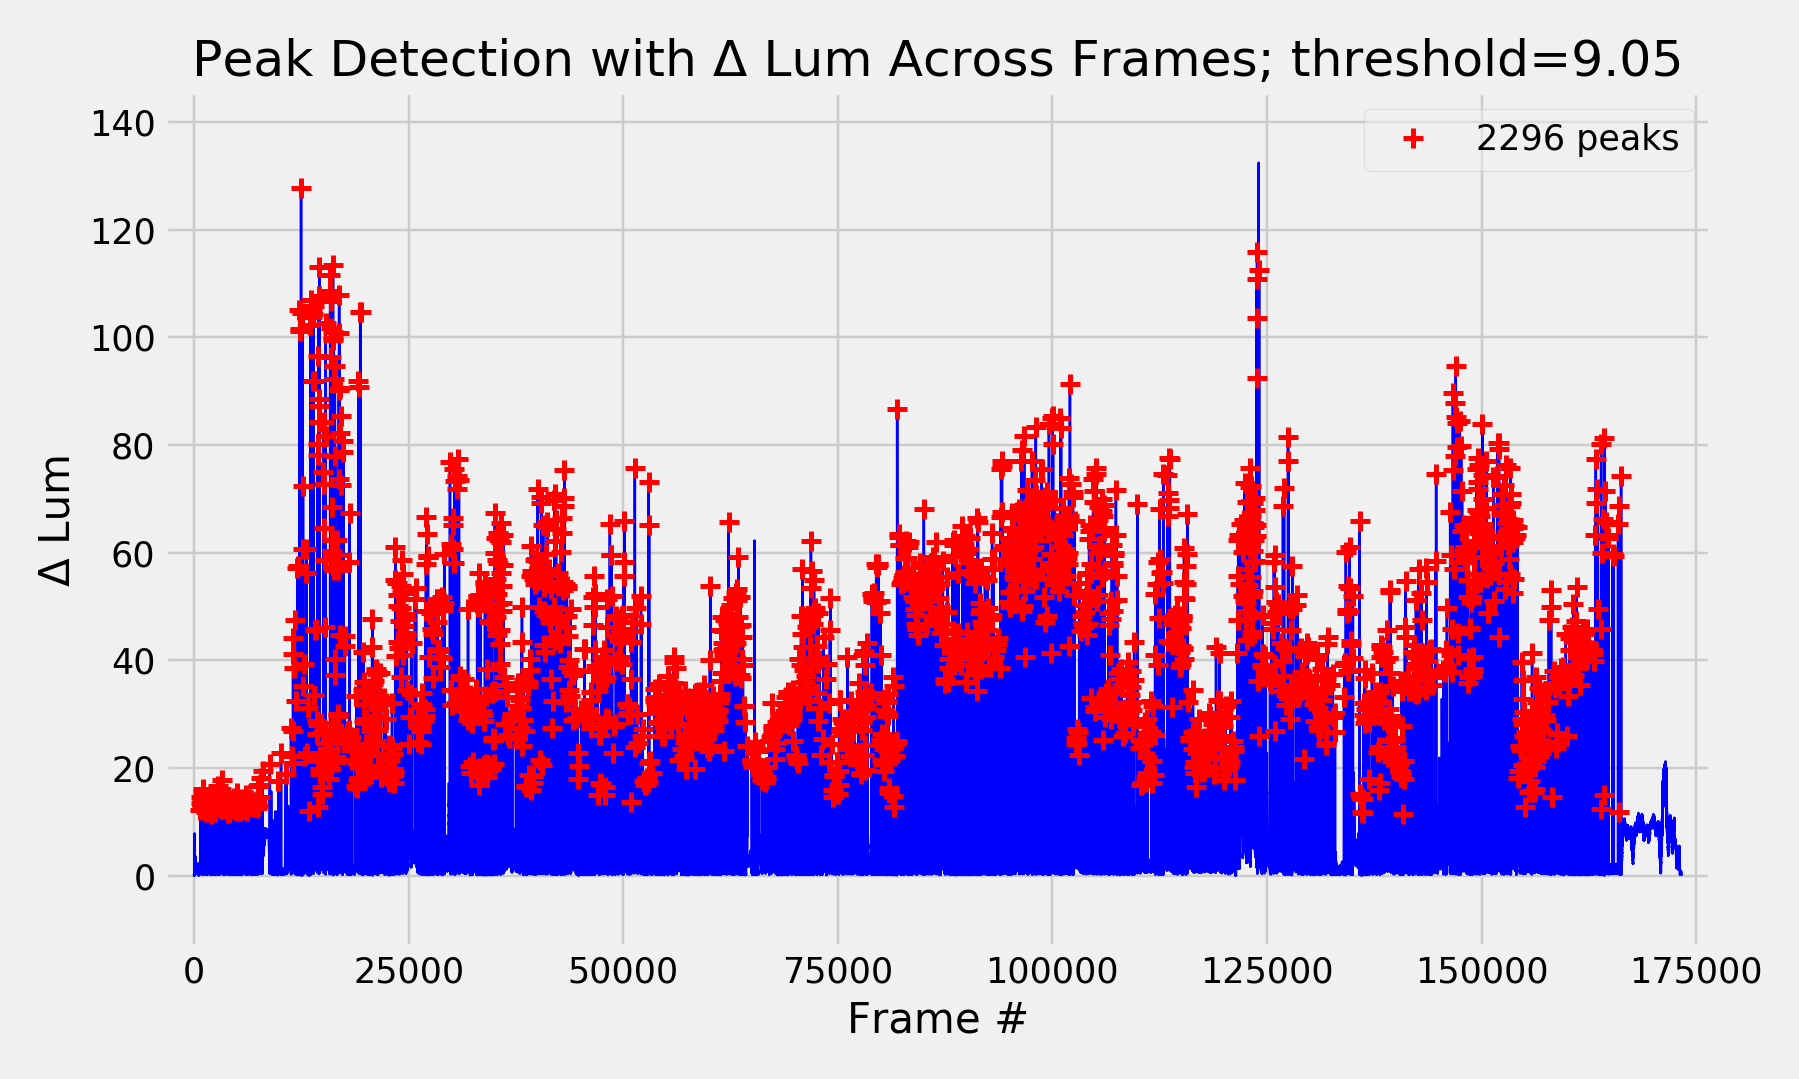

In [16]:
subset = data['delta_lum']
#subset = data['delta_hue']
#subset = data['delta_sat']
#subset = data['content_val']
peaks = detect_peaks(subset, mph=0, mpd=5, show=True, threshold=subset.std()*1.5)

In [41]:
frames = grab_frames(video_file, (81420, 81433))

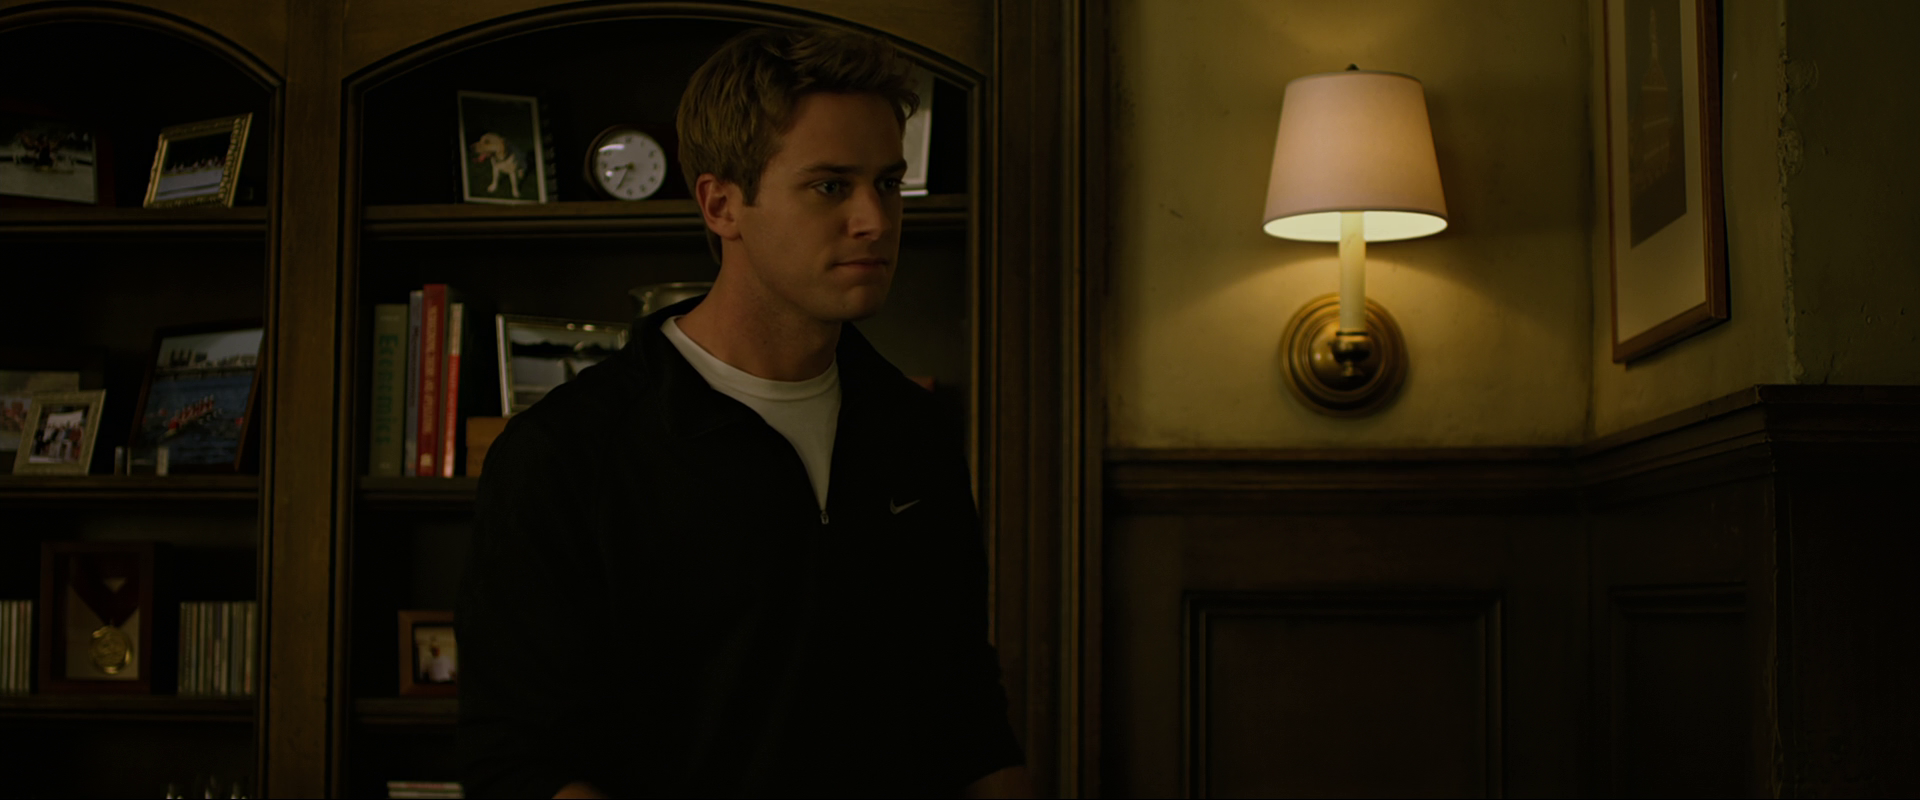

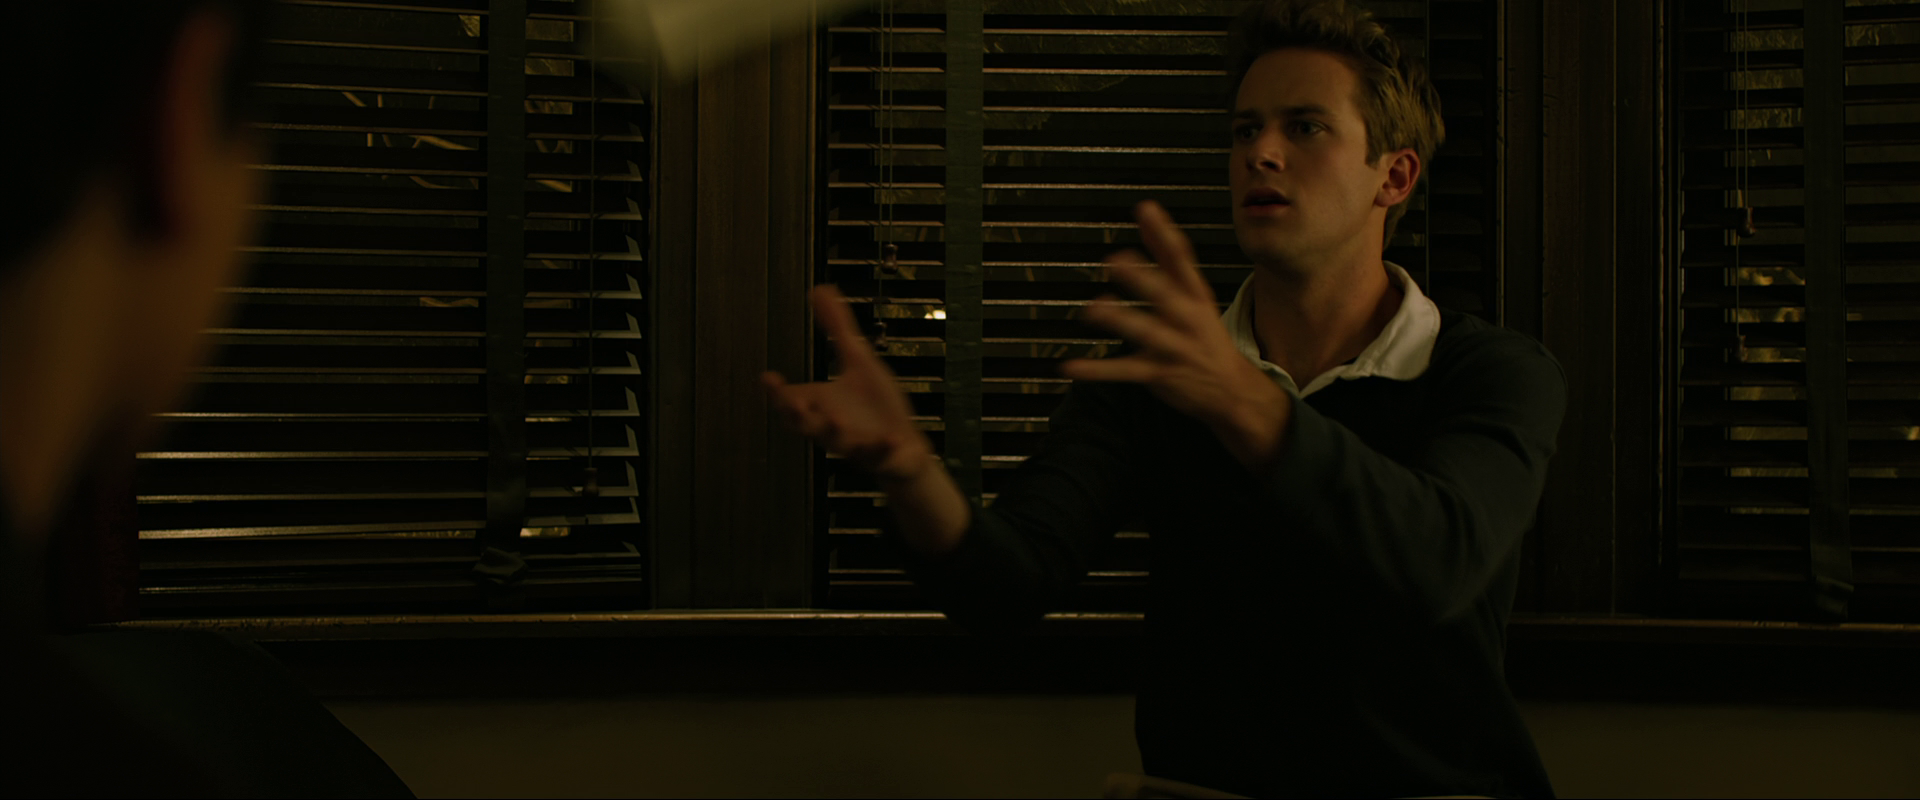

In [42]:
frames[0]
frames[-1]

### Cutting with `split_video_ffmpeg`

In order to make sure macOS's Finder could preview the split files, we add an option to ffmpeg to encode audio -- `a:c mp3` -- instead of the default behavior of copying the audio codec. 

In [4]:
from scenedetect.frame_timecode import FrameTimecode
from scenedetect.video_splitter import split_video_ffmpeg

In [12]:
get_fps = lambda fname: cv2.VideoCapture(fname).get(cv2.CAP_PROP_FPS)
fps = get_fps(video_file)

In [13]:
FT = lambda x: FrameTimecode(x, fps)
scene_list = []

for i in range(len(peaks)):
    if i == 0: scene_list.append((FT(0), FT(int(peaks[i]))))
    else:      scene_list.append((FT(int(peaks[i-1]+3)), FT(int(peaks[i]))))
    # the +3 is added above based on practical observation

In [14]:
%%capture
for i,splitter in enumerate(scene_list, start=1):
    split_video_ffmpeg([video_file], [splitter], output_file_template=f'{splits_dir}shot#{i:04d}.mp4', video_name='')